Este conjunto de datos se utiliza para la segmentación de fases de gestos en videos grabados con un sensor Microsoft Kinect. El dataset ya ha sido preprocesado, con los archivos conteniendo información tanto en forma de posiciones espaciales (coordenadas X, Y, Z) de puntos de articulación clave (manos, muñeca, cabeza y columna) como de velocidades y aceleraciones vectoriales y escalares de las extremidades.

El objetivo principal de este dataset es predecir las fases de gestos en una secuencia temporal, categorizando cada momento de la gesticulación en una de las siguientes clases: Descanso (D), Preparación (P), Golpe (S), Sujeción (H) y Retracción (R). Estas fases corresponden a diferentes etapas de un gesto, como el inicio, el movimiento y el retorno del gesto. El desafío es utilizar esta información para entrenar modelos que puedan segmentar correctamente los gestos a partir de las posiciones y movimientos de las extremidades, lo que se traduce en una clasificación precisa de cada fase en un video.

Estos videos fueron segmentados manualmente por expertos, lo que proporciona un conjunto de ground truth necesario para entrenar y evaluar modelos de predicción.

1-18: Posiciones (X, Y, Z) de 6 puntos de articulación: mano izquierda, mano derecha, muñeca izquierda, muñeca derecha, cabeza, columna vertebral.
19: timestamp: Marca de tiempo de cada frame.
20-32: Velocidades y aceleraciones vectoriales y escalares de las manos y muñecas (X, Y, Z).

Cada fila corresponde a un frame de video y contiene estas características para clasificar la fase del gesto.

In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import optuna
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier,GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import mlflow
import mlflow.sklearn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU


In [147]:
folder_path = "C:/Users/Finar/One_finarq_staf/OneDrive/Documentos/Proyecto Modelos/proyecto-modelos/data/Classification"

In [148]:
csv_files = [f for f in os.listdir(folder_path) if f.endswith('_va3.csv')]

In [4]:
dfs = []
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    dfs.append(df)


In [107]:
df = pd.concat(dfs, ignore_index=True)

In [108]:
df

,1,2,3,4,5,6,7,8,9,10,...,24,25,26,27,28,29,30,31,32,Phase
0,-0.005009,-0.000964,0.000573,0.008623,0.005667,0.001302,-0.000631,0.000130,-0.000048,0.007762,...,1.880800e-04,0.005133,0.010400,0.000646,0.007871,0.004631,0.000963,0.000092,0.000438,D
1,0.004905,0.001209,-0.000649,0.004737,0.003166,0.000819,-0.000572,-0.000015,0.000023,0.002706,...,-7.500000e-07,0.005093,0.005756,0.000573,0.003459,0.000730,0.000332,0.000012,0.000433,D
2,-0.002393,-0.000216,0.000136,0.003028,0.001212,0.000336,-0.000449,0.000017,0.000047,0.002868,...,-3.920000e-05,0.002406,0.003279,0.000452,0.003261,0.002412,0.000852,0.000042,0.000202,D
3,-0.001394,-0.000242,0.000056,0.001182,0.000575,0.000225,-0.000479,-0.000050,0.000104,0.001171,...,-3.184000e-05,0.001416,0.001334,0.000493,0.001358,0.000313,0.000611,0.000029,0.000596,D
4,-0.000156,-0.000004,0.000023,0.001585,0.000630,0.000094,-0.000303,0.000097,0.000065,0.001579,...,-2.015000e-05,0.000158,0.001709,0.000325,0.001713,0.000203,0.000069,0.000038,0.000069,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9868,-0.003709,-0.006168,0.000786,-0.000155,0.001088,-0.000144,-0.003815,-0.004658,0.000656,0.000060,...,-9.400000e-07,0.007240,0.001109,0.006056,0.000173,0.001976,0.000137,0.001575,0.000051,D
9869,-0.000727,0.001536,-0.000211,0.000700,-0.000975,0.000067,-0.001147,0.000177,0.000008,0.000423,...,1.234000e-05,0.001712,0.001202,0.001160,0.000515,0.002600,0.000701,0.001738,0.000124,D
9870,0.003074,0.007870,-0.000962,0.000526,-0.000779,0.000090,0.002786,0.005035,-0.000606,0.000413,...,2.327000e-05,0.008504,0.000944,0.005786,0.000431,0.002007,0.000071,0.001697,0.000112,D
9871,0.003297,0.008467,-0.001035,0.000578,-0.000740,0.000101,0.002947,0.005385,-0.000652,0.000580,...,1.541000e-05,0.009145,0.000944,0.006173,0.000699,0.000229,0.000023,0.000139,0.000113,D


In [109]:
df.isnull().sum().sum()

np.int64(0)

In [110]:
class_distribution = df['Phase'].value_counts()
class_distribution

Phase
S    2950
D    2741
P    2097
R    1087
H     998
Name: count, dtype: int64

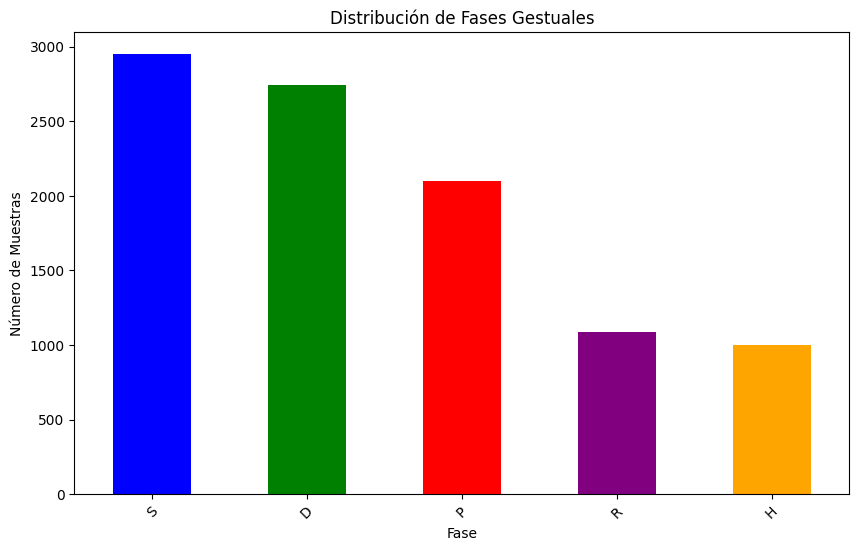

In [111]:
plt.figure(figsize=(10, 6))
class_distribution.plot(kind='bar', color=['blue', 'green', 'red', 'purple', 'orange'])
plt.title('Distribución de Fases Gestuales')
plt.xlabel('Fase')
plt.ylabel('Número de Muestras')
plt.xticks(rotation=45)
plt.show()

Antriormente se pudo observar que existe un desblanceo en las clases debido a a muestra claramente que algunas clases tienen miles de muestras (2500-3000) mientras otras tienen significativamente menos (500-1000 o menos).La clase mayoritaria parece tener aproximadamente 6 veces más muestras que las clases minoritarias, lo que constituye un desbalanceo severo. Esto puede afectar a nuestros modelos.

Como solución se implementará una técnica combinada de SMOTE y undersampling, que consistirá en aumentar las clases minoritarias (H, R, P) para mejorar su representación y reducir el sesgo del modelo hacia las clases mayoritarias. Las clases mayoritarias (D, S) serán ligeramente reducidas para evitar que dominen el entrenamiento, manteniendo un equilibrio que permita un aprendizaje más justo y efectivo sin perder información relevante. Esta estrategia se aplicará exclusivamente sobre el conjunto de datos de entrenamiento para preservar la validez de la evaluación del modelo. La cantidad de datos para cada clase fue seleccionada considerando el tamaño original de las clases en el entrenamiento, asegurando que las clases minoritarias se incrementen de forma razonable sin generar un exceso de datos sintéticos, mientras que las mayoritarias se ajustan para mantener una proporción equilibrada y evitar sobreajuste.

In [112]:
#Separar en X and Y 
X = df.drop('Phase', axis=1) 
y = df['Phase']

In [113]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [114]:
print("Distribución original de y:")
print(y.value_counts())
print("\nDistribución en y_train:")
print(y_train.value_counts())
print("\nDistribución en y_test:")
print(y_test.value_counts())

Distribución original de y:
Phase
S    2950
D    2741
P    2097
R    1087
H     998
Name: count, dtype: int64

Distribución en y_train:
Phase
S    2065
D    1919
P    1468
R     761
H     698
Name: count, dtype: int64

Distribución en y_test:
Phase
S    885
D    822
P    629
R    326
H    300
Name: count, dtype: int64


In [115]:
def balancear_clases(X_train, y_train, verbose=True):
    over = {
        'H': 2000,
        'R': 2100,
        'P': 2400,
    }

    under = {
        'D': y_train.value_counts()['D'], 
        'S': y_train.value_counts()['S'],
    }

    smote = SMOTE(sampling_strategy=over, random_state=42)
    undersampler = RandomUnderSampler(sampling_strategy=under, random_state=42)

    pipeline = Pipeline(steps=[('smote', smote), ('under', undersampler)])

    X_train_bal, y_train_bal = pipeline.fit_resample(X_train, y_train)

    if verbose:
        print("\nDistribución balanceada:")
        print(pd.Series(y_train_bal).value_counts())

    return X_train_bal, y_train_bal

In [116]:
X_train_bal, y_train_bal = balancear_clases(X_train, y_train)


Distribución balanceada:
Phase
P    2400
R    2100
S    2065
H    2000
D    1919
Name: count, dtype: int64


In [117]:
X_train = X_train_bal
y_train = y_train_bal

In [118]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((10484, 32), (10484,), (2962, 32), (2962,))

In [ ]:
def train_and_log_models(X_train, y_train, X_test, y_test):
    models = {
        'knn': KNeighborsClassifier(n_neighbors=3),
        'cart': DecisionTreeClassifier(),
        'svm': SVC(),
        'bayes': GaussianNB(),
        'bag': BaggingClassifier(n_estimators=100),
        'rf': RandomForestClassifier(n_estimators=100),
        'et': ExtraTreesClassifier(n_estimators=100),
        'gbm': GradientBoostingClassifier(n_estimators=100)
    }

    reports = {}

    for name, model in models.items():
        with mlflow.start_run(run_name=name):
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            acc = accuracy_score(y_test, y_pred)
            mlflow.log_metric("accuracy", acc)

            report_str = classification_report(y_test, y_pred)
            reports[name] = report_str

            mlflow.log_param("classification_report", report_str)

            mlflow.sklearn.log_model(model, artifact_path=name)

    return reports


In [137]:
resultados = train_and_log_models(X_train_bal, y_train_bal, X_test, y_test)

2025/05/14 18:39:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/05/14 18:39:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/05/14 18:39:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/05/14 18:39:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/05/14 18:41:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/05/14 18:41:44 

In [140]:
items = list(resultados.items())
for i in range(0, 2):
    model_name, report = items[i]
    print(f"Reporte de {model_name}:\n{report}")
    print("="*70)


Reporte de knn:
              precision    recall  f1-score   support

           D       0.68      0.71      0.70       822
           H       0.46      0.63      0.53       300
           P       0.55      0.58      0.56       629
           R       0.43      0.59      0.50       326
           S       0.75      0.50      0.60       885

    accuracy                           0.60      2962
   macro avg       0.58      0.60      0.58      2962
weighted avg       0.63      0.60      0.60      2962

Reporte de cart:
              precision    recall  f1-score   support

           D       0.66      0.58      0.61       822
           H       0.34      0.42      0.37       300
           P       0.45      0.45      0.45       629
           R       0.37      0.48      0.42       326
           S       0.56      0.52      0.54       885

    accuracy                           0.51      2962
   macro avg       0.48      0.49      0.48      2962
weighted avg       0.52      0.51      0.51 

In [141]:
items = list(resultados.items())
for i in range(0, 2):
    model_name, report = items[i]
    print(f"Reporte de {model_name}:\n{report}")
    print("="*70)


Reporte de knn:
              precision    recall  f1-score   support

           D       0.68      0.71      0.70       822
           H       0.46      0.63      0.53       300
           P       0.55      0.58      0.56       629
           R       0.43      0.59      0.50       326
           S       0.75      0.50      0.60       885

    accuracy                           0.60      2962
   macro avg       0.58      0.60      0.58      2962
weighted avg       0.63      0.60      0.60      2962

Reporte de cart:
              precision    recall  f1-score   support

           D       0.66      0.58      0.61       822
           H       0.34      0.42      0.37       300
           P       0.45      0.45      0.45       629
           R       0.37      0.48      0.42       326
           S       0.56      0.52      0.54       885

    accuracy                           0.51      2962
   macro avg       0.48      0.49      0.48      2962
weighted avg       0.52      0.51      0.51 

In [142]:
for i in range(2, 4):
    model_name, report = items[i]
    print(f"Reporte de {model_name}:\n{report}")
    print("="*70)


Reporte de svm:
              precision    recall  f1-score   support

           D       0.59      0.68      0.63       822
           H       0.28      0.36      0.31       300
           P       0.45      0.50      0.47       629
           R       0.40      0.63      0.49       326
           S       0.71      0.34      0.45       885

    accuracy                           0.50      2962
   macro avg       0.48      0.50      0.47      2962
weighted avg       0.54      0.50      0.50      2962

Reporte de bayes:
              precision    recall  f1-score   support

           D       0.48      0.27      0.35       822
           H       0.16      0.71      0.26       300
           P       0.39      0.22      0.28       629
           R       0.29      0.22      0.25       326
           S       0.57      0.34      0.43       885

    accuracy                           0.32      2962
   macro avg       0.38      0.35      0.31      2962
weighted avg       0.44      0.32      0.34

In [143]:
for i in range(4, 6):
    model_name, report = items[i]
    print(f"Reporte de {model_name}:\n{report}")
    print("="*70)


Reporte de bag:
              precision    recall  f1-score   support

           D       0.75      0.80      0.77       822
           H       0.59      0.62      0.61       300
           P       0.60      0.56      0.58       629
           R       0.51      0.63      0.57       326
           S       0.71      0.63      0.67       885

    accuracy                           0.66      2962
   macro avg       0.63      0.65      0.64      2962
weighted avg       0.66      0.66      0.66      2962

Reporte de rf:
              precision    recall  f1-score   support

           D       0.74      0.80      0.77       822
           H       0.58      0.57      0.58       300
           P       0.61      0.57      0.59       629
           R       0.54      0.65      0.59       326
           S       0.71      0.64      0.67       885

    accuracy                           0.66      2962
   macro avg       0.64      0.65      0.64      2962
weighted avg       0.67      0.66      0.66   

In [144]:
for i in range(6, 8):
    model_name, report = items[i]
    print(f"Reporte de {model_name}:\n{report}")
    print("="*70)


Reporte de et:
              precision    recall  f1-score   support

           D       0.74      0.85      0.79       822
           H       0.72      0.57      0.63       300
           P       0.65      0.59      0.62       629
           R       0.61      0.61      0.61       326
           S       0.71      0.71      0.71       885

    accuracy                           0.70      2962
   macro avg       0.69      0.67      0.67      2962
weighted avg       0.70      0.70      0.69      2962

Reporte de gbm:
              precision    recall  f1-score   support

           D       0.71      0.64      0.67       822
           H       0.36      0.57      0.44       300
           P       0.49      0.53      0.51       629
           R       0.41      0.65      0.50       326
           S       0.69      0.43      0.53       885

    accuracy                           0.55      2962
   macro avg       0.53      0.56      0.53      2962
weighted avg       0.59      0.55      0.55   

Extra Trees, Random Forest y BAG lograron las mejores precisiones 70% y 66% y 66% debido a su capacidad para manejar relaciones complejas y balancear clases. Modelos simples como Naive Bayes con 32% y Decision Tree con 50% rindieron peor, probablemente por su menor capacidad para capturar patrones complejos y desequilibrios. Esto indica que los métodos ensemble son más adecuados para este dataset.

# MLP

In [161]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [176]:
X_train.shape,X_test.shape,X_val.shape, y_train.shape,y_test.shape,y_val.shape

((6709, 32), (2962, 32), (1678, 32), (6709,), (2962,), (1678,))

In [219]:
def build_mlp_classifier(input_shape, num_classes, architecture_type="basic"):
    model = Sequential()

    if architecture_type == "basic":
        model.add(Dense(128, input_shape=(input_shape,), activation='relu', kernel_regularizer=l2(0.001)))
        model.add(Dropout(0.2))
        model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
        model.add(Dropout(0.2))

    elif architecture_type == "deep":
        model.add(Dense(256, input_shape=(input_shape,), kernel_regularizer=l2(0.0005)))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.1))
        model.add(Dropout(0.4))

        model.add(Dense(512, kernel_regularizer=l2(0.0005)))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.1))
        model.add(Dropout(0.4))

        model.add(Dense(256, kernel_regularizer=l2(0.0005)))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.1))
        model.add(Dropout(0.3))

        model.add(Dense(128, kernel_regularizer=l2(0.0005)))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.1))
        model.add(Dropout(0.2))

    elif architecture_type == "wide":
        model.add(Dense(512, input_shape=(input_shape,), kernel_regularizer=l2(0.0005)))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.1))
        model.add(Dropout(0.4))

        model.add(Dense(256, kernel_regularizer=l2(0.0005)))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.1))
        model.add(Dropout(0.3))

        model.add(Dense(128, kernel_regularizer=l2(0.0005)))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.1))
        model.add(Dropout(0.2))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


In [220]:
def train_mlp_mlflow_labelencode(X_train, y_train, X_val, y_val, input_shape, num_classes, architecture):
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_val_enc = le.transform(y_val)

    model = build_mlp_classifier(input_shape, num_classes, architecture)

    early_stop = EarlyStopping(monitor='val_loss', patience=70, restore_best_weights=True)

    with mlflow.start_run(run_name=f"MLP_{architecture}"):
        history = model.fit(
            X_train, y_train_enc,
            validation_data=(X_val, y_val_enc),
            epochs=100,
            batch_size=32,
            verbose=1,
            callbacks=[early_stop]
        )

        loss, accuracy = model.evaluate(X_val, y_val_enc, verbose=0)

        mlflow.log_param("architecture", architecture)
        mlflow.log_metric("val_loss", loss)
        mlflow.log_metric("val_accuracy", accuracy)

        mlflow.keras.log_model(model, f"mlp_{architecture}")

    return model, history, le

In [221]:
input_shape = X_train.shape[1]
num_classes = len(np.unique(y_train))

architecture = "basic"  

model, history, le = train_mlp_mlflow_labelencode(X_train, y_train, X_val, y_val, input_shape, num_classes, architecture)


Epoch 1/100


c:\Users\Finar\One_finarq_staf\OneDrive\Documentos\Proyecto Modelos\proyecto-modelos\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2271 - loss: 1.6778 - val_accuracy: 0.2479 - val_loss: 1.5767
Epoch 2/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2925 - loss: 1.5530 - val_accuracy: 0.3176 - val_loss: 1.5187
Epoch 3/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3435 - loss: 1.5163 - val_accuracy: 0.3480 - val_loss: 1.5097
Epoch 4/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3554 - loss: 1.5088 - val_accuracy: 0.3754 - val_loss: 1.4912
Epoch 5/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3784 - loss: 1.4848 - val_accuracy: 0.3826 - val_loss: 1.4898
Epoch 6/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3813 - loss: 1.4769 - val_accuracy: 0.3939 - val_loss: 1.4690
Epoch 7/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3996 - loss: 1.4639 - val_accuracy: 0.4118 - val_loss: 1.4567
Epoch 8/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4014 - loss: 1.4542 - val_accuracy: 0.4172

2025/05/14 20:23:20 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/05/14 20:23:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [222]:
y_test_enc = le.transform(y_test)
y_pred_proba = model.predict(X_test)
y_pred = y_pred_proba.argmax(axis=1)


print(classification_report(y_test_enc, y_pred, target_names=le.classes_))


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
              precision    recall  f1-score   support

           D       0.59      0.57      0.58       822
           H       0.19      0.25      0.21       300
           P       0.39      0.50      0.44       629
           R       0.30      0.67      0.41       326
           S       0.62      0.17      0.26       885

    accuracy                           0.41      2962
   macro avg       0.42      0.43      0.38      2962
weighted avg       0.48      0.41      0.40      2962



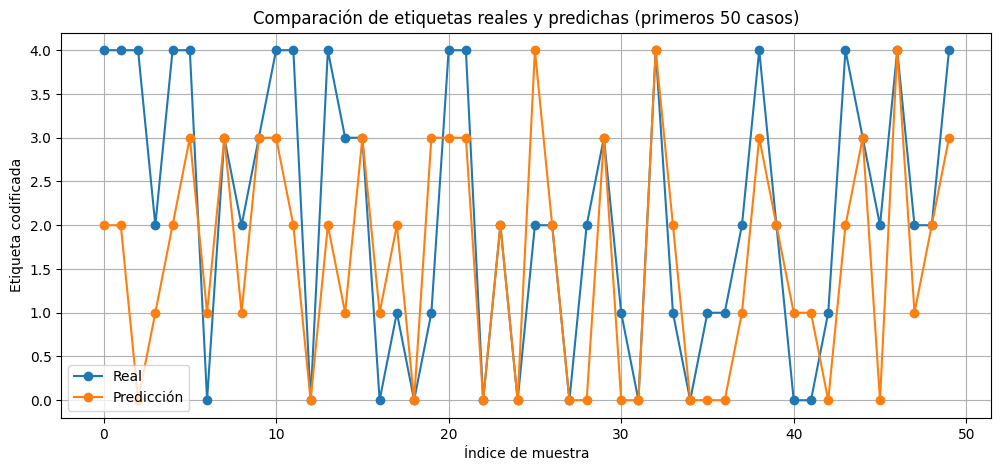

In [223]:
indices = np.arange(50)

plt.figure(figsize=(12, 5))
plt.plot(indices, y_test_enc[:50], label='Real', marker='o')
plt.plot(indices, y_pred[:50], label='Predicción', marker='o')
plt.title('Comparación de etiquetas reales y predichas (primeros 50 casos)')
plt.xlabel('Índice de muestra')
plt.ylabel('Etiqueta codificada')
plt.legend()
plt.grid(True)
plt.show()

In [224]:
input_shape = X_train.shape[1]
num_classes = len(np.unique(y_train))

architecture = "deep"  

model, history, le = train_mlp_mlflow_labelencode(X_train, y_train, X_val, y_val, input_shape, num_classes, architecture)

c:\Users\Finar\One_finarq_staf\OneDrive\Documentos\Proyecto Modelos\proyecto-modelos\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Finar\One_finarq_staf\OneDrive\Documentos\Proyecto Modelos\proyecto-modelos\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.3498 - loss: 2.0223 - val_accuracy: 0.2282 - val_loss: 2.0589
Epoch 2/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4272 - loss: 1.8355 - val_accuracy: 0.3278 - val_loss: 1.9918
Epoch 3/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4484 - loss: 1.7448 - val_accuracy: 0.4374 - val_loss: 1.8039
Epoch 4/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4569 - loss: 1.6867 - val_accuracy: 0.3552 - val_loss: 2.0676
Epoch 5/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4664 - loss: 1.6466 - val_accuracy: 0.3397 - val_loss: 1.9344
Epoch 6/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4766 - loss: 1.6095 - val_accuracy: 0.4267 - val_loss: 1.6456
Epoch 7/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4780 - loss: 1.5643 - val_accuracy: 0.3010 - val_loss: 2.6120
Epoch 8/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4903 - loss: 1.5245 - val_accu

2025/05/14 20:25:01 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/05/14 20:25:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [225]:
y_test_enc = le.transform(y_test)
y_pred_proba = model.predict(X_test)
y_pred = y_pred_proba.argmax(axis=1)


print(classification_report(y_test_enc, y_pred, target_names=le.classes_))


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           D       0.47      0.86      0.61       822
           H       0.20      0.04      0.06       300
           P       0.50      0.35      0.41       629
           R       0.38      0.60      0.47       326
           S       0.62      0.30      0.41       885

    accuracy                           0.47      2962
   macro avg       0.43      0.43      0.39      2962
weighted avg       0.48      0.47      0.43      2962



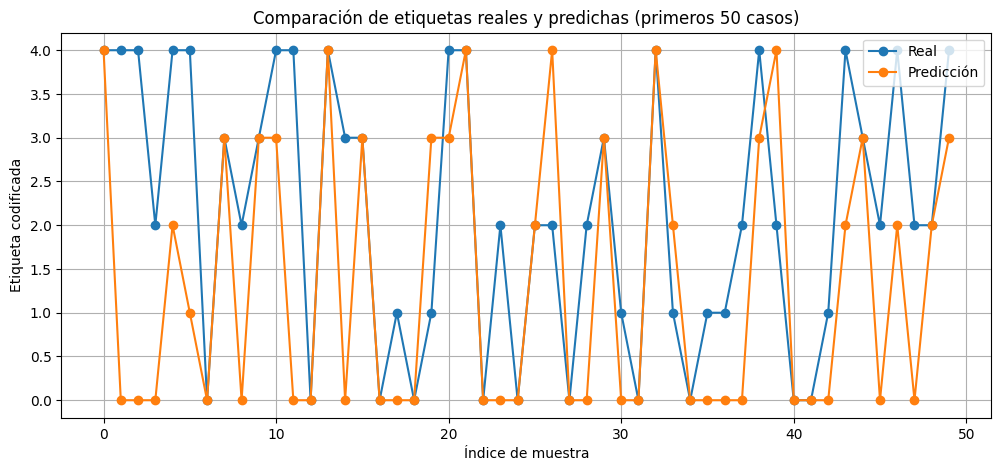

In [226]:
indices = np.arange(50)

plt.figure(figsize=(12, 5))
plt.plot(indices, y_test_enc[:50], label='Real', marker='o')
plt.plot(indices, y_pred[:50], label='Predicción', marker='o')
plt.title('Comparación de etiquetas reales y predichas (primeros 50 casos)')
plt.xlabel('Índice de muestra')
plt.ylabel('Etiqueta codificada')
plt.legend()
plt.grid(True)
plt.show()

In [227]:
input_shape = X_train.shape[1]
num_classes = len(np.unique(y_train))

architecture = "wide"  

model, history, le = train_mlp_mlflow_labelencode(X_train, y_train, X_val, y_val, input_shape, num_classes, architecture)


c:\Users\Finar\One_finarq_staf\OneDrive\Documentos\Proyecto Modelos\proyecto-modelos\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Finar\One_finarq_staf\OneDrive\Documentos\Proyecto Modelos\proyecto-modelos\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3706 - loss: 1.8275 - val_accuracy: 0.2175 - val_loss: 1.9226
Epoch 2/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4401 - loss: 1.6229 - val_accuracy: 0.2777 - val_loss: 1.8139
Epoch 3/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4547 - loss: 1.5566 - val_accuracy: 0.3480 - val_loss: 1.7132
Epoch 4/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4712 - loss: 1.5175 - val_accuracy: 0.3242 - val_loss: 1.8674
Epoch 5/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4911 - loss: 1.4649 - val_accuracy: 0.3361 - val_loss: 1.9549
Epoch 6/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5069 - loss: 1.4383 - val_accuracy: 0.3355 - val_loss: 2.0402
Epoch 7/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4893 - loss: 1.4341 - val_accuracy: 0.3361 - val_loss: 2.0805
Epoch 8/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4978 - loss: 1.4149 - val_accu

2025/05/14 20:26:22 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/05/14 20:26:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [228]:
y_test_enc = le.transform(y_test)
y_pred_proba = model.predict(X_test)
y_pred = y_pred_proba.argmax(axis=1)


print(classification_report(y_test_enc, y_pred, target_names=le.classes_))


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           D       0.40      0.95      0.57       822
           H       0.12      0.04      0.06       300
           P       0.59      0.17      0.27       629
           R       0.43      0.39      0.41       326
           S       0.65      0.34      0.44       885

    accuracy                           0.45      2962
   macro avg       0.44      0.38      0.35      2962
weighted avg       0.49      0.45      0.40      2962



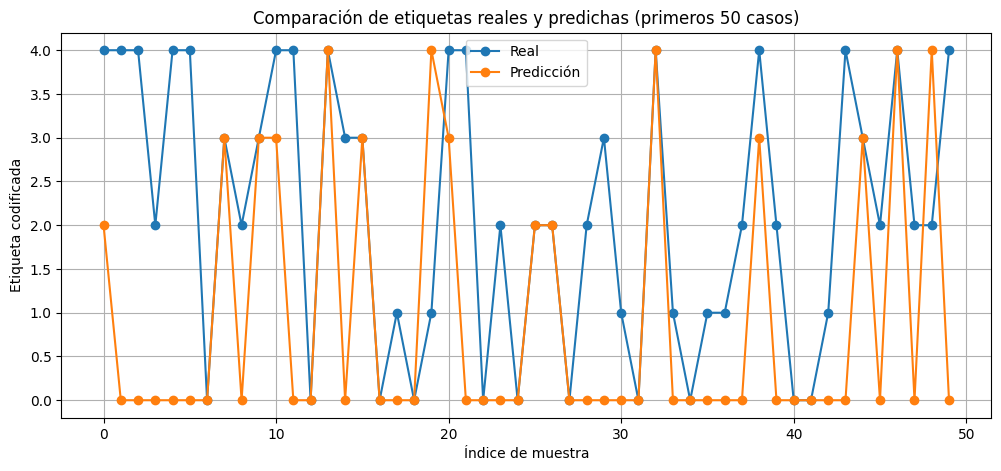

In [230]:
indices = np.arange(50)

plt.figure(figsize=(12, 5))
plt.plot(indices, y_test_enc[:50], label='Real', marker='o')
plt.plot(indices, y_pred[:50], label='Predicción', marker='o')
plt.title('Comparación de etiquetas reales y predichas (primeros 50 casos)')
plt.xlabel('Índice de muestra')
plt.ylabel('Etiqueta codificada')
plt.legend()
plt.grid(True)
plt.show()